In [1]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

In [2]:
# SEEDING

os.environ['PYTHONHASHSEED'] = str(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# HYPERPARAMETERS

batch_size = 8
epochs = 80
height = 256
width = 256
lr = 1e-4

In [4]:
# PATHS

dataset_path = './content/drive/MyDrive/Dataset-Outline-Detection/small-dataset'
files = './content/drive/MyDrive/Dataset-Outline-Detection/files'
model_file = '/content/drive/MyDrive/Check/model.h5'
log_file = '/content/drive/MyDrive/Check/log.csv'


In [5]:
# BUILDING UNET MODEL

def convolution (inputs, filters):
  x = Conv2D(filters,3,padding="same")(inputs)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(filters,3,padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  return x

In [6]:
def encoder(inputs,filters):
  x = convolution(inputs,filters)
  y = MaxPool2D((2,2))(x)
  return x , y

In [7]:
def decoder(inputs,skip,filters):
  x = Conv2DTranspose(filters,(2,2), strides=2, padding="same")(inputs)
  x = Concatenate()([x, skip])
  x = convolution(x, filters)
  return x


In [8]:
def unet_model(input):
  inputs = Input(input)

  #### ---- ENCODER ---- ####
  s1, p1 = encoder(inputs,64)
  s2, p2 = encoder(p1, 128)
  s3, p3 = encoder(p2, 256)
  s4, p4 = encoder(p3, 512)

  #### ---- BRIDGE ---- ####
  b1 = convolution(p4,1024)

  #### ---- DECODER ---- ####
  d1 = decoder(b1, s4, 512)
  d2 = decoder(d1, s3, 256)
  d3 = decoder(d2, s2, 128)
  d4 = decoder(d3, s1, 64)

  outputs = Conv2D(1,1,padding="same", activation= "sigmoid")(d4)

  model = Model(inputs, outputs, name="UNET")

  return model


In [9]:
def load_data(path):
  train_x = sorted(glob(os.path.join("/content/drive/MyDrive/Check/train_images", "*")))
  train_y = sorted(glob(os.path.join("/content/drive/MyDrive/Check/train_masks","*")))

  valid_x = sorted(glob(os.path.join("/content/drive/MyDrive/Check/valid_images","*")))
  valid_y = sorted(glob(os.path.join("/content/drive/MyDrive/Check/valid_masks","*")))

  return (train_x, train_y), (valid_x, valid_y)

In [10]:
def read_image(path):
  path = path.decode()
  x = cv2.imread(path,cv2.IMREAD_COLOR)
  x = cv2.resize(x, (256, 256))
  x = x / 255.0
  return x

In [11]:
def read_mask(path):
  path = path.decode()
  x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  x = cv2.resize(x, (256, 256))
  x = x/255.0
  x = np.expand_dims(x,axis=-1)
  return x

In [13]:
# tf data pipeline

def tf_parse(x, y):
  def _parse(x,y):
    x = read_image(x)
    y = read_mask(y)
    return x, y
  x,y = tf.numpy_function(_parse, [x,y], [tf.float64, tf.float64])
  x.set_shape([height,width,3])
  y.set_shape([height,width,1])

  return x,y

In [14]:
def tf_dataset(x,y, batch=8):
  dataset = tf.data.Dataset.from_tensor_slices((x,y))
  dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
  dataset = dataset.batch(batch)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)
  return dataset

### **TRAINING**

In [15]:
(train_x, train_y), (valid_x, valid_y) = load_data(dataset_path)
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")
print(train_x)


Train: 0 - 0
Valid: 0 - 0
[]


In [16]:
train_dataset = tf_dataset(train_x, train_y, batch = batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch = batch_size)


In [17]:
# type(train_dataset)
# for x, y in train_dataset :
#   print(x.shape, y.shape)

In [18]:
input_shape = (height, width, 3)
model = unet_model(input_shape)


In [19]:
model.summary()

Model: "UNET"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [20]:
opt = tf.keras.optimizers.Adam(lr)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["acc"])

In [21]:
callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    CSVLogger(log_file),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
]

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=/content/drive/MyDrive/Check/model.h5

In [22]:
model.fit(
    train_dataset,
    validation_data = valid_dataset,
    epochs = epochs,
    callbacks = callbacks
)

NameError: name 'callbacks' is not defined

## **LOAD AND TEST THE MODEL**

In [28]:
# %pip install tensorflow
from tensorflow.keras.models import load_model
import cv2
import numpy as np
loaded_model = load_model('../Edge Detection Model/image_outline_detection.h5')


TypeError: Error when deserializing class 'Conv2DTranspose' using config={'name': 'conv2d_transpose_4', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'output_padding': None}.

Exception encountered: Unrecognized keyword arguments passed to Conv2DTranspose: {'groups': 1}

In [3]:
# HYPERPARAMETERS

height = 256
width = 256


In [4]:
def preprocess_image(image_path):
    x = cv2.imread(image_path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (width, height))
    x = x / 255.0
    x = np.expand_dims(x, axis=0)  # Add batch dimension
    return x


In [5]:
def predict(model, image_path):
    x = preprocess_image(image_path)
    y_pred = model.predict(x)
    return y_pred[0]  # Remove batch dimension

image_path_to_test = 'camera.jpeg'
predictions = predict(loaded_model, image_path_to_test)


1/1 [==============================] - 3s 3s/step


In [6]:
def postprocess_predictions(predictions, threshold=0.5):
    predictions[predictions >= threshold] = 1
    predictions[predictions < threshold] = 0
    return predictions

thresholded_predictions = postprocess_predictions(predictions)

In [7]:
def create_outline(mask, outline_width=3):
    kernel = np.ones((outline_width, outline_width), np.uint8)
    dilated_mask = cv2.dilate(mask, kernel, iterations=1)
    eroded_mask = cv2.erode(mask, kernel, iterations=1)
    outline = dilated_mask - eroded_mask
    return outline
outline_image = create_outline(thresholded_predictions)

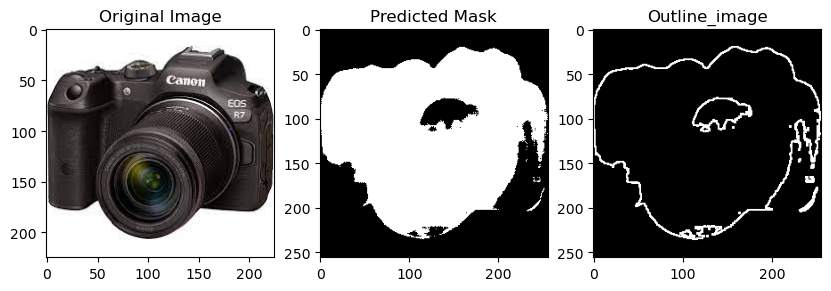

In [8]:
import matplotlib.pyplot as plt

def visualize_result(original_image, predicted_mask):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')

    plt.subplot(1,3,3)
    plt.imshow(outline_image, cmap='gray')
    plt.title('Outline_image')

    plt.show()

original_image = cv2.imread(image_path_to_test, cv2.IMREAD_COLOR)
visualize_result(original_image, thresholded_predictions)
